# Purpose:

2015-04-01 (Wednesday)

In [2]:
# Table of Searches:


## Imports:

In [3]:
# imports
import csv
import itertools
import os
import fnmatch
import re

import pandas as pd
import numpy as np
import datetime as dt

from shapely.geometry import Polygon, Point
from geopy.distance import great_circle
from geopandas import GeoDataFrame
import geopandas as gpd
from descartes import PolygonPatch

import scipy

import munch

from spartan.utils.maps import gps

In [4]:
# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import ggplot as gp

pd.set_option('display.max_columns', 60)


In [5]:
# set figure characteristics

# size
sns.set_context("talk")

# style
sns.set_style("whitegrid")

## File paths:

In [6]:
# define paths to files
traps_gps_path = "/home/gus/Documents/YalePostDoc/project_stuff/G_pallidipes_kenya/legacy_data/John_Enyaru_from_2013/john_enyaru_2013_GPS.tsv"
traps_gps_shp_path = "/home/gus/Documents/YalePostDoc/project_stuff/G_pallidipes_kenya/legacy_data/John_Enyaru_from_2013/john_enyaru_2013_GPS.shp"

ne_base_dir = '/home/gus/OLD_DROPBOX/GIS/Natural_Earth/packages/Natural_Earth_quick_start'


In [7]:
def recode_gps_coords(df):
    
    new_lat = df.Latitude.apply(gps.clean_coord)
    df.Latitude = new_lat
    
    new_lon = df.Longitude.apply(gps.clean_coord)
    df.Longitude = new_lon
    
##########################################

def lat_lon_to_geometry(df,lat='Latitude',lon='Longitude'):
    df["geometry"] = map(Point, df[lon], df[lat])
    
##########################################
def save_geojson(gdf,path):
    with open(path, 'w') as geo_out:
        geo_out.write(gdf.to_json())
    

In [8]:
def load_nat_earth(base_dir, pattern='*10m_*.shp'):
    paths = []
    for root, dirs, files in os.walk(base_dir):
        for filename in fnmatch.filter(files, pattern):
            paths.append(os.path.join(root, filename))
            
    layers = munch.Munch()
    
    for p in paths:
        name = os.path.splitext(os.path.split(p)[-1])[0]
        layers[name] = gpd.read_file(p)
        
    return layers

---
## Load  and save trap GPS

In [9]:
traps_gps = pd.read_csv(traps_gps_path, sep='\t')
recode_gps_coords(traps_gps)
lat_lon_to_geometry(traps_gps)
traps_gps = GeoDataFrame(traps_gps, geometry='geometry')

In [10]:
traps_gps.head()

,Location,Latitude,Longitude,Description,geometry
0,Ruma National Park,-0.587398,34.299799,Ruma National Park,POINT (34.2997992 -0.5873984)
1,Ruma National Park,-0.638200,34.309739,Ruma National Park,POINT (34.30973947 -0.63819953)
2,Ruma National Park,-0.587398,34.299799,Ruma National Park,POINT (34.2997992 -0.58739849)
3,Ruma National Park,-0.638200,34.309739,Ruma National Park,POINT (34.30973947 -0.63819953)
4,Koibos,0.183370,36.110170,Lake Bogoria (200m radius),POINT (36.11017 0.18337)


In [11]:
traps_gps.to_file(traps_gps_shp_path)

## Load Natural Earth layers

In [39]:
ne_layers = load_nat_earth(base_dir=ne_base_dir, pattern='10m_*.shp')

In [41]:
ne_layers.keys()

['ne_10m_admin_0_disputed_areas',
 'ne_10m_geography_regions_polys',
 'ne_10m_geography_marine_polys',
 'ne_10m_admin_0_boundary_lines_land',
 'ne_10m_populated_places',
 'ne_10m_admin_1_states_provinces_shp',
 'ne_10m_ocean',
 'ne_10m_coastline',
 'ne_10m_admin_1_states_provinces_lines_shp',
 'ne_10m_geography_regions_points',
 'ne_10m_admin_0_boundary_lines_maritime_indicator',
 'ne_10m_admin_0_map_units',
 'ne_10m_rivers_lake_centerlines',
 'ne_10m_urban_areas',
 'ne_10m_admin_0_scale_rank_minor_islands',
 'ne_10m_admin_0_boundary_lines_disputed_areas',
 'ne_10m_lakes',
 'ne_10m_rivers_lake_centerlines_scale_rank',
 'ne_10m_admin_0_map_subunits',
 'ne_10m_geography_regions_elevation_points',
 'ne_10m_minor_islands']

In [43]:
def layer_extents_from_gdfs(layers,points_gdf,margin=0,):
    """
    Returns intersection of layers with rectangle inferred from data in points_gdf.
    """
    layer_extents = munch.Munch()

    # define the coordinates at the extent of our point data for our map
    margin_width = margin
    lon_range = [points_gdf['Longitude'].min() - margin_width, points_gdf['Longitude'].max() + margin_width]
    lat_range = [points_gdf['Latitude'].min() - margin_width, points_gdf['Latitude'].max() + margin_width]

    # create a rectangle from these coordinates
    spatial_extent = Polygon([(lon_range[0], lat_range[0]),
        (lon_range[0], lat_range[1]),
        (lon_range[1], lat_range[1]),
        (lon_range[1], lat_range[0])])


    for name, layer in layers.iteritems():

        # get the shapes with geopandas intersects, which pulls the full shape
        layer_extents[name] = layer[layer['geometry'].intersects(spatial_extent)]

    return layer_extents

In [58]:
map_layers = layer_extents_from_gdfs(ne_layers,traps_gps)

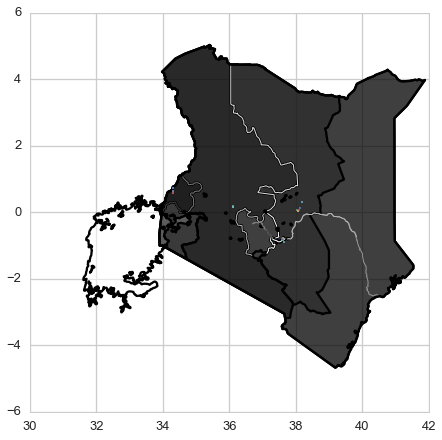

In [91]:
map_layers.ne_10m_admin_1_states_provinces_shp.plot();
map_layers.ne_10m_admin_1_states_provinces_lines_shp.plot();
map_layers.ne_10m_admin_0_map_units.plot();
map_layers.ne_10m_rivers_lake_centerlines.plot();
map_layers.ne_10m_urban_areas.plot();
map_layers.ne_10m_lakes.plot();
map_layers.ne_10m_rivers_lake_centerlines_scale_rank.plot();
map_layers.ne_10m_admin_0_map_subunits.plot();

traps_gps.plot();

In [39]:
lat_lon_to_geometry(village_gps)
village_gps = GeoDataFrame(village_gps, geometry='geometry')

# with open(village_gps_geojson, 'w') as geo_out:
#     geo_out.write(village_gps.to_json())

village_gps.head()

,Latitude,Longitude,Location,geometry
Location,,,,
ABO,2.466775,32.56499,ABO,POINT (32.56498999999999 2.466775)
ACA,2.270080,32.52053,ACA,POINT (32.52053 2.27008)
AG,2.413985,32.59915,AG,POINT (32.59915 2.413985)
AIN,3.304225,31.11941,AIN,POINT (31.11941 3.304225)
AKA,2.372370,32.67522,AKA,POINT (32.67522 2.37237)


<function matplotlib.pyplot.text>

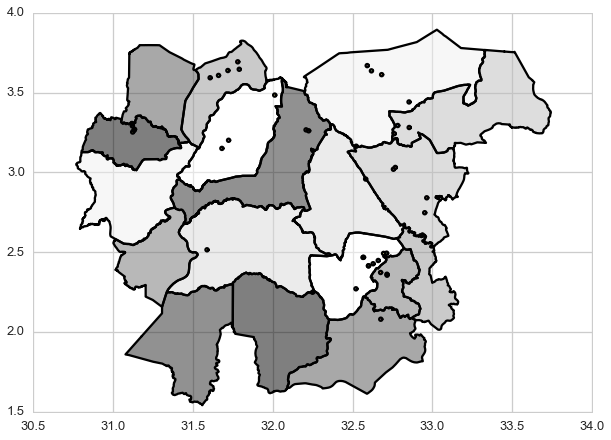

In [30]:
districts.plot();
village_gps.buffer(0.01).plot();
plt.text